## Prepare Monthly Time Series Data

In [91]:
# time_series_preparation.py

import pandas as pd

# Load the monthly sales data
df_monthly = pd.read_csv("monthly_sales.csv", parse_dates=["Date"])

# Set 'Date' as index
df_monthly = df_monthly.set_index("Date").sort_index()

# Resample to ensure no missing months (fill missing with 0 sales)
df_monthly = df_monthly.resample("MS").sum().fillna(0)

# Rename column for clarity
df_monthly = df_monthly.rename(columns={"Sales": "Monthly_Sales"})

# Save clean version
df_monthly.to_csv("monthly_sales_clean.csv")

print("✅ Monthly time series prepared.")
print(df_monthly.head())


✅ Monthly time series prepared.
            Order_Year  Order_Month  Monthly_Sales
Date                                              
2015-01-01        2015            1   3.196284e+06
2015-02-01        2015            2   1.016976e+06
2015-03-01        2015            3   1.242130e+07
2015-04-01        2015            4   6.215734e+06
2015-05-01        2015            5   5.319968e+06


## Time Series Decomposition


<Figure size 1400x1000 with 0 Axes>

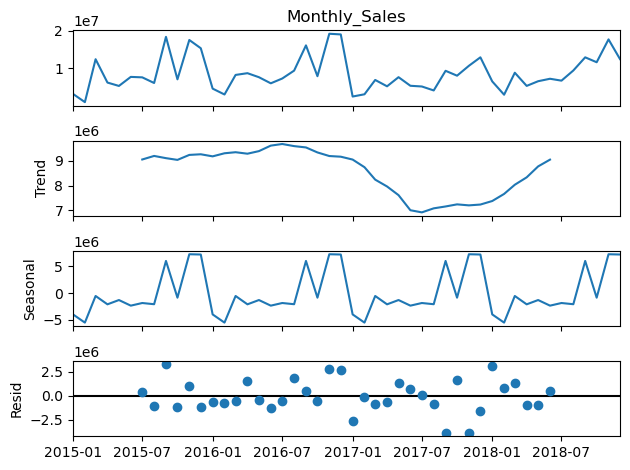

In [93]:
# decomposition.py

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load clean monthly time series
df_monthly = pd.read_csv("monthly_sales_clean.csv", parse_dates=["Date"], index_col="Date")

# Decompose the series (you can choose model='multiplicative' if seasonality increases over time)
decomposition = seasonal_decompose(df_monthly["Monthly_Sales"], model='additive')

# Plot components
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.tight_layout()
plt.show()


## Naive Forecast Implementation

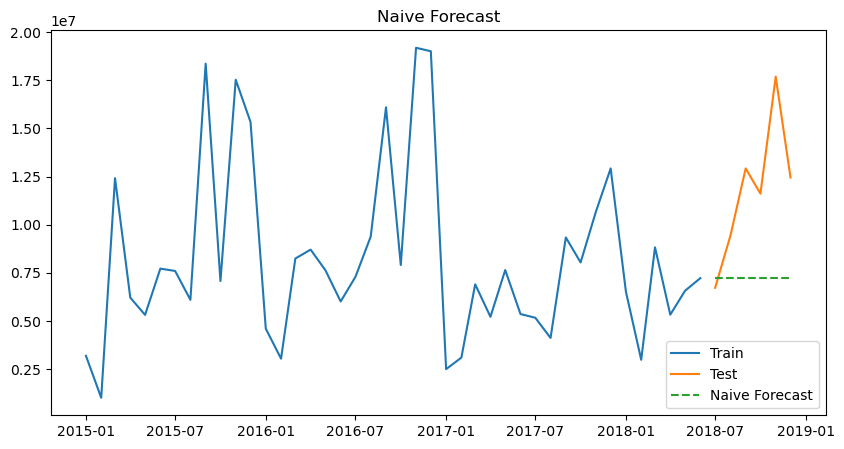

In [95]:
# naive_forecast.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("monthly_sales_clean.csv", parse_dates=["Date"], index_col="Date")

# Split into train and test
train = df.iloc[:-6]   # all but last 6 months
test = df.iloc[-6:]    # last 6 months for testing

# Naive forecast (last train value repeated)
naive_forecast = pd.Series(train["Monthly_Sales"].iloc[-1], index=test.index)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train.index, train["Monthly_Sales"], label="Train")
plt.plot(test.index, test["Monthly_Sales"], label="Test")
plt.plot(test.index, naive_forecast, label="Naive Forecast", linestyle="--")
plt.legend()
plt.title("Naive Forecast")
plt.show()


## Naive Forecast Evaluation Metrics

In [97]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test["Monthly_Sales"], naive_forecast)
rmse = np.sqrt(mean_squared_error(test["Monthly_Sales"], naive_forecast))
mape = np.mean(np.abs((test["Monthly_Sales"] - naive_forecast) / test["Monthly_Sales"])) * 100

print("📊 MAE:", round(mae, 2))
print("📉 RMSE:", round(rmse, 2))
print("📈 MAPE:", round(mape, 2), "%")


📊 MAE: 4745484.9
📉 RMSE: 5679401.08
📈 MAPE: 35.63 %


## 3-Month Moving Average Forecast

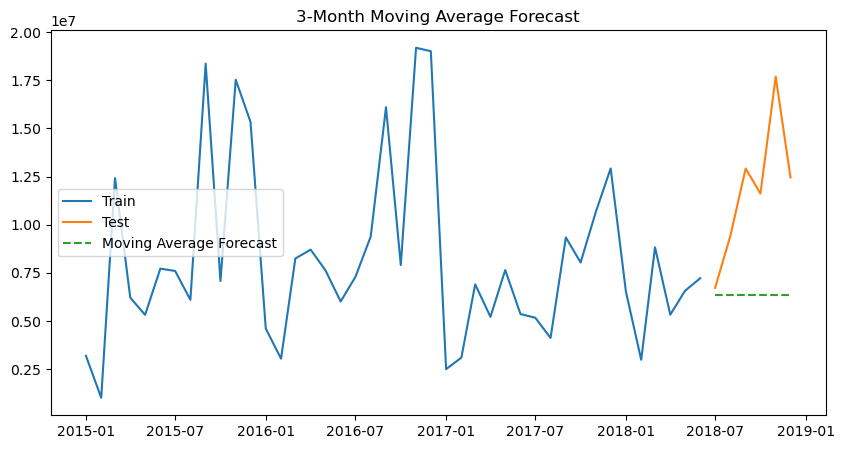

In [99]:

# Rolling average (window=3 months)
rolling_forecast = train["Monthly_Sales"].rolling(window=3).mean().iloc[-1]
moving_avg_forecast = pd.Series(rolling_forecast, index=test.index)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train.index, train["Monthly_Sales"], label="Train")
plt.plot(test.index, test["Monthly_Sales"], label="Test")
plt.plot(test.index, moving_avg_forecast, label="Moving Average Forecast", linestyle="--")
plt.legend()
plt.title("3-Month Moving Average Forecast")
plt.show()


## 3-Month Moving Average Forecast Evaluation

In [101]:

mae = mean_absolute_error(test["Monthly_Sales"], moving_avg_forecast)
rmse = np.sqrt(mean_squared_error(test["Monthly_Sales"], moving_avg_forecast))
mape = np.mean(np.abs((test["Monthly_Sales"] - moving_avg_forecast) / test["Monthly_Sales"])) * 100

print("📊 MAE:", round(mae, 2))
print("📉 RMSE:", round(rmse, 2))
print("📈 MAPE:", round(mape, 2), "%")


📊 MAE: 5427881.87
📉 RMSE: 6384880.92
📈 MAPE: 40.99 %


## SARIMA Forecast Implementation and Evaluation


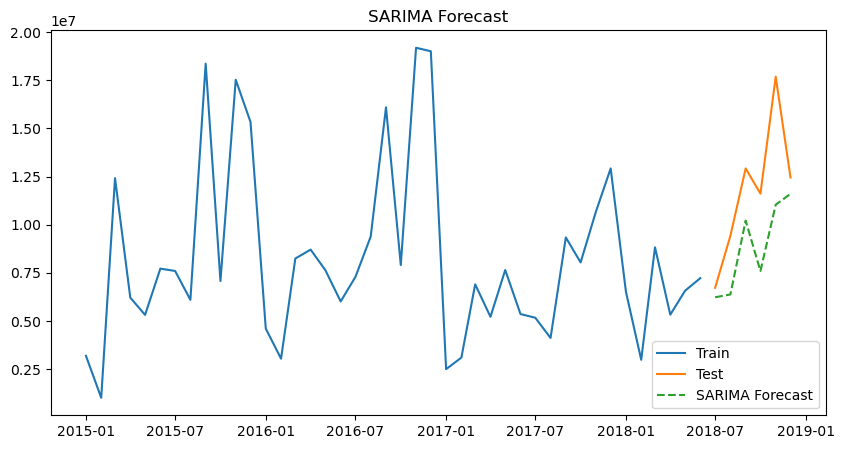

📊 MAE: 2959632.15
📉 RMSE: 3603863.25
📈 MAPE: 23.25 %


In [103]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Load monthly sales data
df = pd.read_csv("monthly_sales_clean.csv", parse_dates=["Date"], index_col="Date")
train = df.iloc[:-6]
test = df.iloc[-6:]

# Fit SARIMA model (manually start with basic config: SARIMA(p,d,q)(P,D,Q,12))
model = SARIMAX(train["Monthly_Sales"],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Forecast
forecast = results.predict(start=test.index[0], end=test.index[-1], dynamic=False)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train.index, train["Monthly_Sales"], label="Train")
plt.plot(test.index, test["Monthly_Sales"], label="Test")
plt.plot(test.index, forecast, label="SARIMA Forecast", linestyle="--")
plt.legend()
plt.title("SARIMA Forecast")
plt.show()

# Evaluation
mae = mean_absolute_error(test["Monthly_Sales"], forecast)
rmse = np.sqrt(mean_squared_error(test["Monthly_Sales"], forecast))
mape = np.mean(np.abs((test["Monthly_Sales"] - forecast) / test["Monthly_Sales"])) * 100

print("📊 MAE:", round(mae, 2))
print("📉 RMSE:", round(rmse, 2))
print("📈 MAPE:", round(mape, 2), "%")


## Forecast Evaluation Function

In [105]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_forecast(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    mape = np.mean(np.abs((true - predicted) / true)) * 100
    return mae, rmse, mape


In [106]:
# Last known value is used for all predictions
naive_forecast = df_monthly["Monthly_Sales"].shift(1)

# Drop the first row (NaN)
naive_forecast = naive_forecast.dropna()
actual = df_monthly["Monthly_Sales"].iloc[1:]

naive_mae, naive_rmse, naive_mape = evaluate_forecast(actual, naive_forecast)
print(f"Naive - MAE: {naive_mae:.2f}, RMSE: {naive_rmse:.2f}, MAPE: {naive_mape:.2f}%")


Naive - MAE: 4079100.17, RMSE: 5647290.75, MAPE: 62.32%


In [107]:
moving_avg_forecast = df_monthly["Monthly_Sales"].rolling(window=3).mean().shift(1)
moving_avg_forecast = moving_avg_forecast.dropna()
actual_ma = df_monthly["Monthly_Sales"].iloc[3:]

ma_mae, ma_rmse, ma_mape = evaluate_forecast(actual_ma, moving_avg_forecast)
print(f"Moving Avg - MAE: {ma_mae:.2f}, RMSE: {ma_rmse:.2f}, MAPE: {ma_mape:.2f}%")


Moving Avg - MAE: 3491480.89, RMSE: 4802347.65, MAPE: 58.42%


## Comparison of Forecasts: Naive and Moving Average

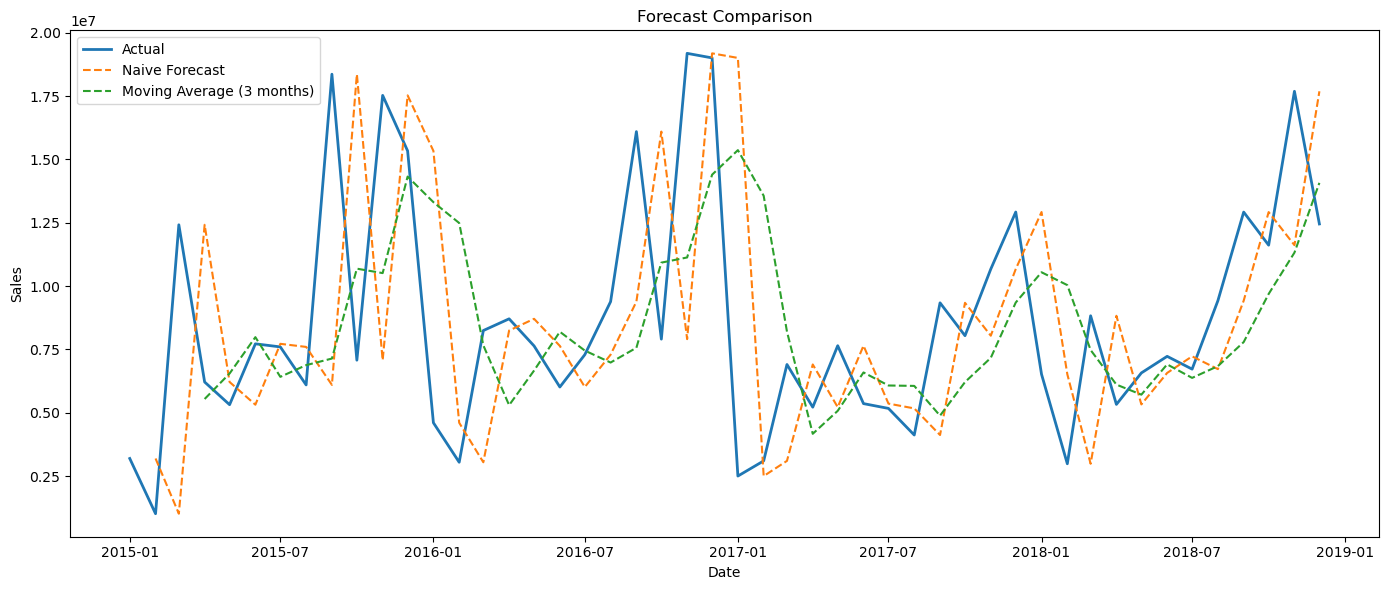

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df_monthly["Monthly_Sales"], label="Actual", linewidth=2)
plt.plot(naive_forecast, label="Naive Forecast", linestyle="--")
plt.plot(moving_avg_forecast, label="Moving Average (3 months)", linestyle="--")
plt.title("Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()


📉 Naive Forecast
MAE: 3291430.15
RMSE: 4610722.73
MAPE: 34.61%


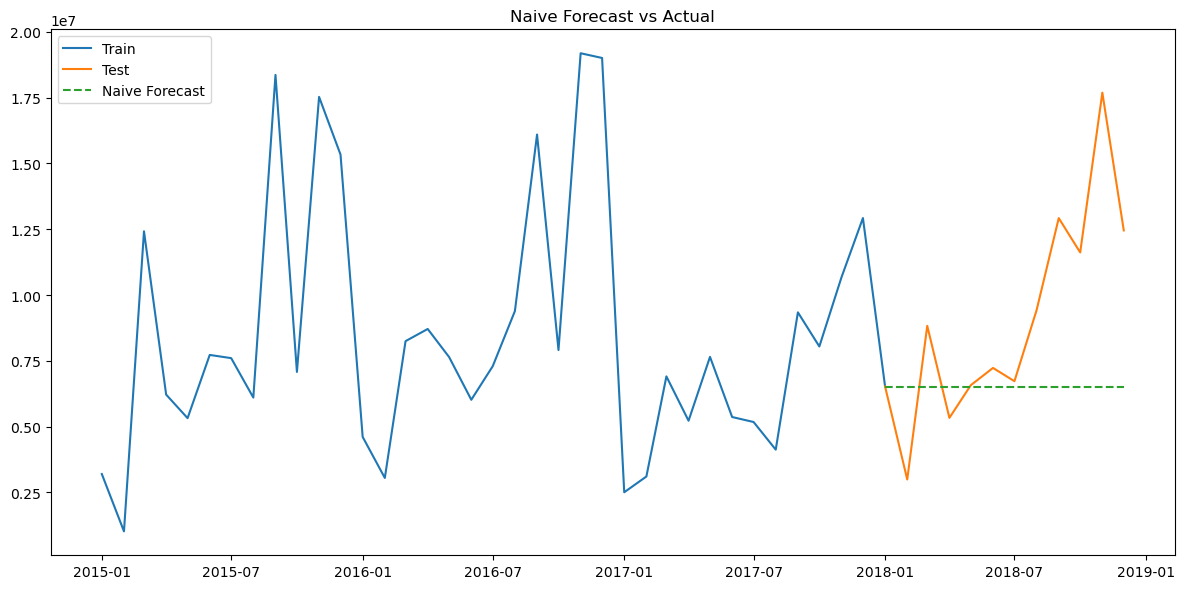

In [110]:
# naive_forecast.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data
df = pd.read_csv("monthly_sales_clean.csv", parse_dates=["Date"], index_col="Date")

# Train-test split
split_date = "2018-01-01"
train = df[:split_date]
test = df[split_date:]

# Naive forecast: predict last observed value
naive_forecast = train["Monthly_Sales"].iloc[-1]
test["Naive_Pred"] = naive_forecast

# Evaluation
mae = mean_absolute_error(test["Monthly_Sales"], test["Naive_Pred"])
rmse = np.sqrt(mean_squared_error(test["Monthly_Sales"], test["Naive_Pred"]))
mape = np.mean(np.abs((test["Monthly_Sales"] - test["Naive_Pred"]) / test["Monthly_Sales"])) * 100

print("📉 Naive Forecast")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train["Monthly_Sales"], label="Train")
plt.plot(test["Monthly_Sales"], label="Test")
plt.plot(test["Naive_Pred"], label="Naive Forecast", linestyle="--")
plt.title("Naive Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()


## Moving Average Forecast Implementation

📉 Moving Average Forecast
MAE: 3435280.99
RMSE: 4002113.38
MAPE: 53.16%


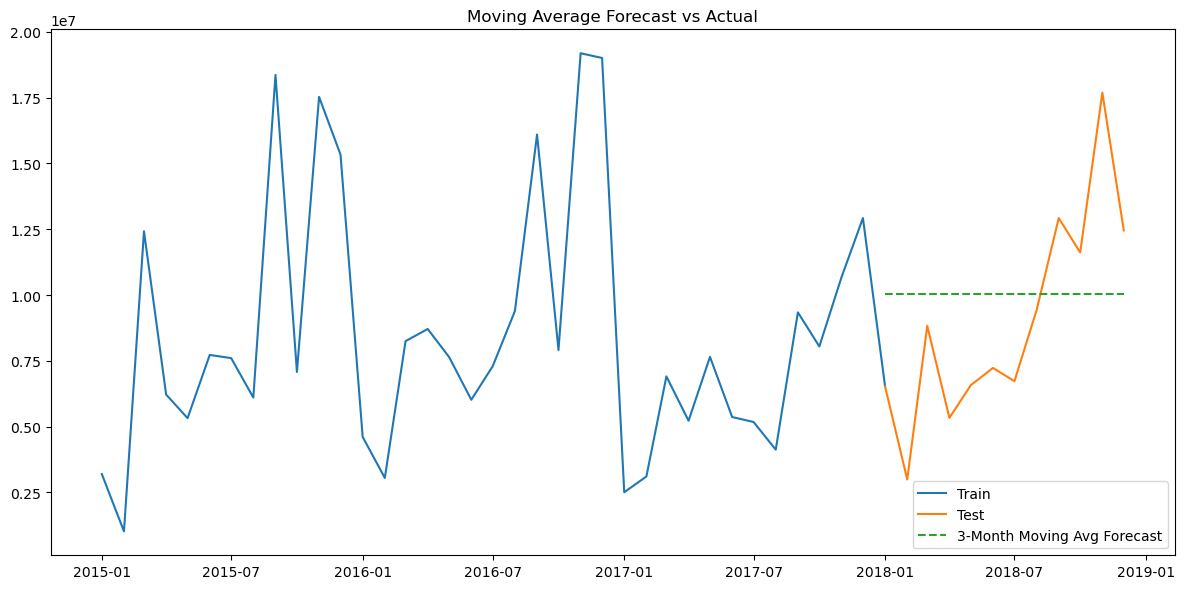

In [112]:
# moving_average_forecast.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data
df = pd.read_csv("monthly_sales_clean.csv", parse_dates=["Date"], index_col="Date")

# Train-test split
split_date = "2018-01-01"
train = df[:split_date]
test = df[split_date:]

# Moving average forecast - rolling window (e.g., last 3 months)
window = 3
rolling_mean = train["Monthly_Sales"].rolling(window=window).mean()

# For forecasting, use the last 3 months average repeatedly
last_rolling_mean = rolling_mean.dropna().iloc[-1]
test["Moving_Avg_Pred"] = last_rolling_mean

# Evaluation
mae = mean_absolute_error(test["Monthly_Sales"], test["Moving_Avg_Pred"])
rmse = np.sqrt(mean_squared_error(test["Monthly_Sales"], test["Moving_Avg_Pred"]))
mape = np.mean(np.abs((test["Monthly_Sales"] - test["Moving_Avg_Pred"]) / test["Monthly_Sales"])) * 100

print("📉 Moving Average Forecast")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train["Monthly_Sales"], label="Train")
plt.plot(test["Monthly_Sales"], label="Test")
plt.plot(test["Moving_Avg_Pred"], label=f"{window}-Month Moving Avg Forecast", linestyle="--")
plt.title("Moving Average Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()


In [113]:
pip install prophet


## Prophet Forecast Implementation

15:25:38 - cmdstanpy - INFO - Chain [1] start processing
15:25:38 - cmdstanpy - INFO - Chain [1] done processing


📈 Prophet Forecast
MAE: 4431221.40
RMSE: 4946380.82
MAPE: 58.05%


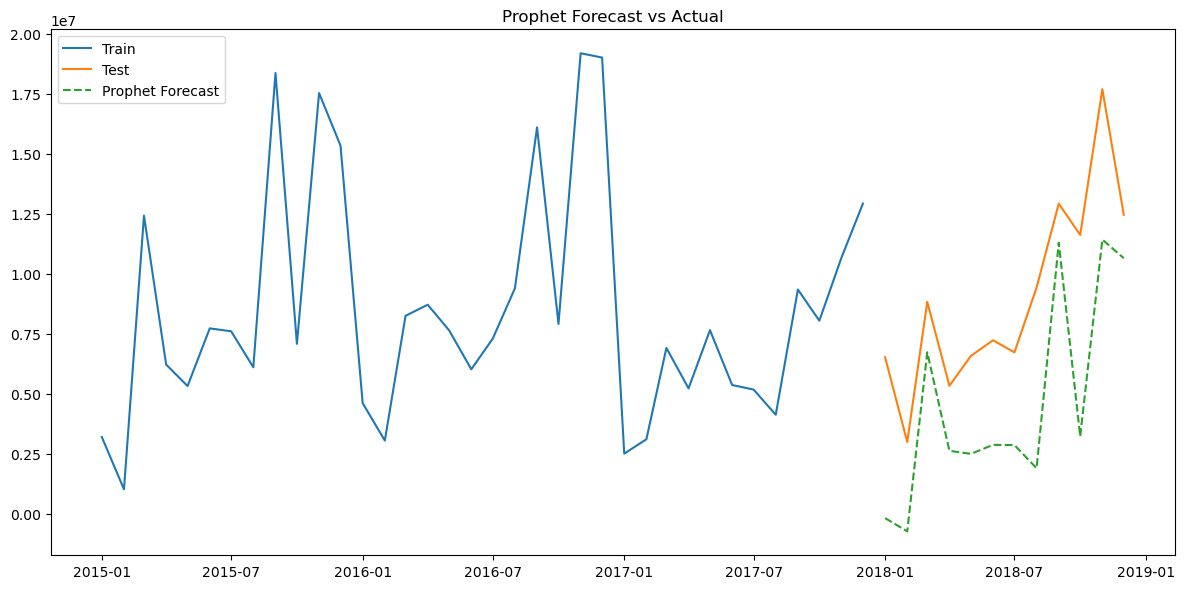

In [115]:
# prophet_forecast.py

import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("monthly_sales_clean.csv", parse_dates=["Date"])
df = df[["Date", "Monthly_Sales"]]
df.columns = ["ds", "y"]  # Prophet requires these column names

# Train-test split
split_date = "2018-01-01"
train = df[df["ds"] < split_date]
test = df[df["ds"] >= split_date]

# Fit the model
model = Prophet()
model.fit(train)

# Create future dataframe for forecasting
future = model.make_future_dataframe(periods=len(test), freq='MS')
forecast = model.predict(future)

# Merge forecast with actual test values
forecast_df = forecast[["ds", "yhat"]].set_index("ds")
test = test.set_index("ds")
test["Prophet_Pred"] = forecast_df["yhat"]

# Evaluation
mae = mean_absolute_error(test["y"], test["Prophet_Pred"])
rmse = np.sqrt(mean_squared_error(test["y"], test["Prophet_Pred"]))
mape = np.mean(np.abs((test["y"] - test["Prophet_Pred"]) / test["y"])) * 100

print("📈 Prophet Forecast")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train["ds"], train["y"], label="Train")
plt.plot(test.index, test["y"], label="Test")
plt.plot(test.index, test["Prophet_Pred"], label="Prophet Forecast", linestyle="--")
plt.title("Prophet Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()


## Aggregate Monthly Sales with Regressors


In [117]:
# monthly_agg_with_regressors.py

import pandas as pd

# Load the full featured dataset
df = pd.read_csv("retail_data_final.csv", parse_dates=["Order Date"])

# Add Order_Year and Order_Month if not already there
df["Order_Year"] = df["Order Date"].dt.year
df["Order_Month"] = df["Order Date"].dt.month

# Aggregate monthly sales and take average of external features
monthly_df = df.groupby(["Order_Year", "Order_Month"]).agg({
    "Sales": "sum",
    "CPI": "mean",
    
    "Gasoline_Price": "mean",
    "holiday_type": "max"  # if any holiday in month
}).reset_index()

# Create a proper datetime column
monthly_df["Date"] = pd.to_datetime(monthly_df["Order_Year"].astype(str) + "-" + monthly_df["Order_Month"].astype(str) + "-01")

# Clean and reorder
monthly_df = monthly_df.sort_values("Date")
monthly_df = monthly_df[["Date", "Sales", "CPI", "Gasoline_Price", "holiday_type"]]
monthly_df = monthly_df.rename(columns={"Sales": "Monthly_Sales"})

# Save to CSV
monthly_df.to_csv("monthly_sales_with_regressors.csv", index=False)
print("✅ Saved monthly_sales_with_regressors.csv")


✅ Saved monthly_sales_with_regressors.csv


## Prophet Forecast with Regressors

15:25:50 - cmdstanpy - INFO - Chain [1] start processing
15:25:50 - cmdstanpy - INFO - Chain [1] done processing


📊 Prophet with Regressors
MAE: 2796769.32
RMSE: 3246655.65
MAPE: 36.02%


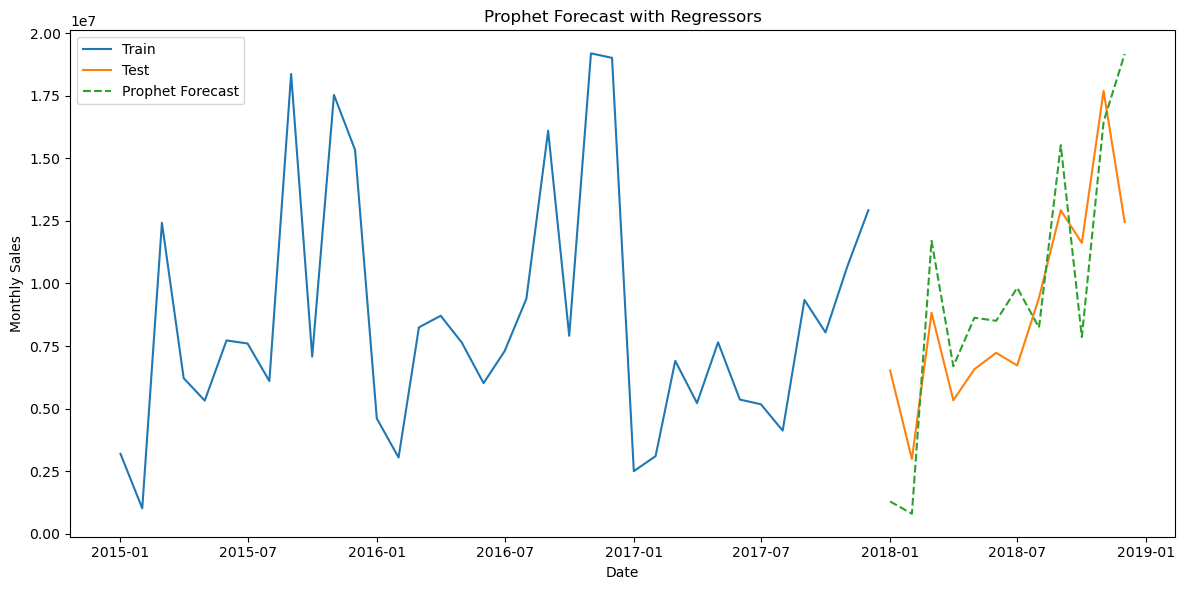

In [119]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("monthly_sales_with_regressors.csv", parse_dates=["Date"])
df = df.rename(columns={"Date": "ds", "Monthly_Sales": "y"})

# Add regressors
regressors = ["CPI", "Gasoline_Price", "holiday_type"]

# Split into train and test
split_date = "2018-01-01"
train = df[df["ds"] < split_date].copy()
test = df[df["ds"] >= split_date].copy()

# Convert 'holiday_type' to a numeric format suitable for Prophet
train['holiday_type_num'] = train['holiday_type'].astype('category').cat.codes
test['holiday_type_num'] = test['holiday_type'].astype('category').cat.codes

# Initialize Prophet with regressors
model = Prophet()
for reg in ["CPI", "Gasoline_Price"]:  # Only add the numeric regressors here
    model.add_regressor(reg)
model.add_regressor('holiday_type_num')  # Add holiday_type_num


# Fit model
model.fit(train[["ds", "y"] + ["CPI", "Gasoline_Price", "holiday_type_num"]])

# Create future dataframe and include regressors
future = df[["ds"] + regressors].copy()  # Create a copy to avoid modifying the original DataFrame
future['holiday_type_num'] = future['holiday_type'].astype('category').cat.codes

forecast = model.predict(future[["ds"] + ["CPI", "Gasoline_Price", "holiday_type_num"]])


# Evaluation
forecast_df = forecast[["ds", "yhat"]].set_index("ds")
test = test.set_index("ds")
test["yhat"] = forecast_df.loc[test.index, "yhat"]

mae = mean_absolute_error(test["y"], test["yhat"])
rmse = np.sqrt(mean_squared_error(test["y"], test["yhat"]))
mape = np.mean(np.abs((test["y"] - test["yhat"]) / test["y"])) * 100

print("📊 Prophet with Regressors")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train["ds"], train["y"], label="Train")
plt.plot(test.index, test["y"], label="Test")
plt.plot(test.index, test["yhat"], label="Prophet Forecast", linestyle="--")
plt.title("Prophet Forecast with Regressors")
plt.xlabel("Date")
plt.ylabel("Monthly Sales")
plt.legend()
plt.tight_layout()
plt.show()


## Prophet Components Visualization

<Figure size 1000x800 with 0 Axes>

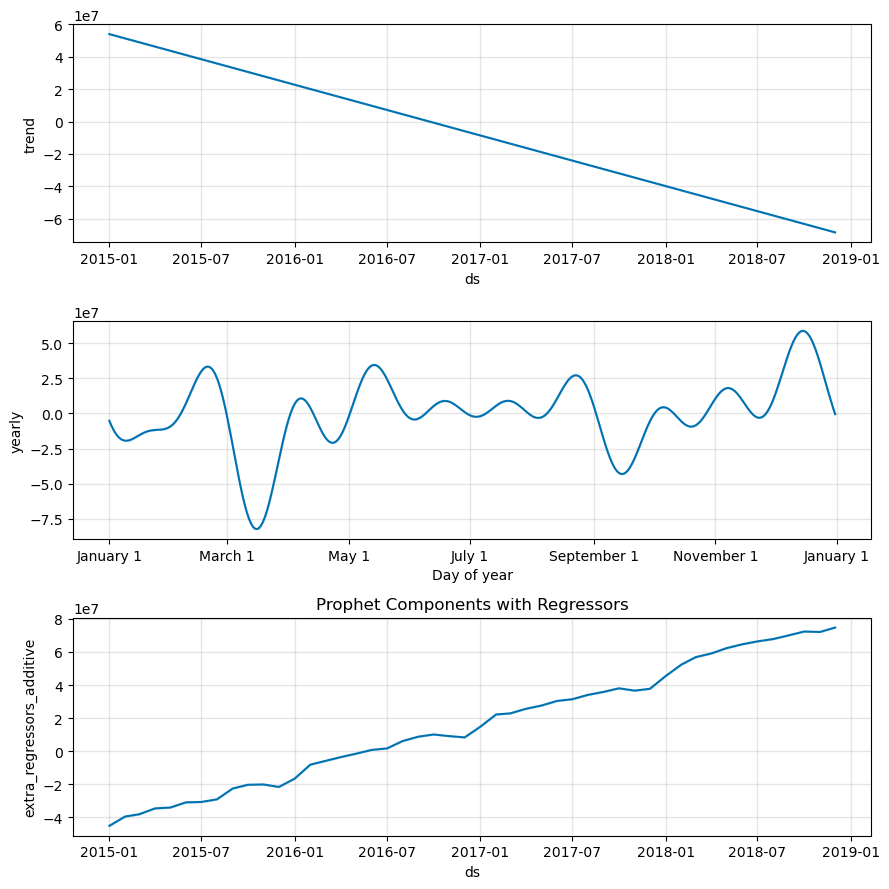

In [121]:
# 1. Visualize Forecast Components (Prophet with Regressors)
plt.figure(figsize=(10, 8))
model.plot_components(forecast)
plt.title("Prophet Components with Regressors")
plt.tight_layout()
plt.show()
